### 3D City Models from Volunteered Public Data

<div class="alert alert-block alert-warning"><b>This notebook will:</b>

> **1. produce an [interactive *pseudo-3D* Building Model visualization](#Section1)** *- via [pydeck](https://deckgl.readthedocs.io/en/latest/) - which a user can navigate, query, share* **that**;
> > **i) [colour buildings by type](#Section1a)** *(to easily visualize building stock)*  
>
> **2. allow the user to execute an application of Spatial Data Science**  
>
>> **i)  [population estimation](#Section2a)** _--with a previous census metric population growth rate and projected (future) population are also possible_  **and**    
>> **ii)  a measure of [Building Volume per Capita](#Section2b).**
>
> **3. propose several [Geography and Sustainable Development Education *conversation starters*](#Section3) for Secondary and Tertiary level students** 

</div>

<div class="alert alert-block alert-danger"><b></b>

***The [suburb](https://github.com/AdrianKriger/geo3D/tree/main/suburb)*** processing option is meant for areas with more than for **2 500 buildings**.</div>

In [1]:
#load the magic

import time
from datetime import timedelta

%matplotlib inline

import os

import requests
import overpass 
import osm2geojson

import json
import geojson
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, shape, mapping
from shapely.ops import transform
import pyproj

from osgeo import gdal, ogr, osr

from openlocationcode import openlocationcode as olc

import city3D

import matplotlib.pyplot as plt
import pydeck as pdk

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#- where do we want to investigate? large= state or province, focus= suburb or census tract / ward
large = 'Western Cape'
focus =  'Woodstock'         # | 'Salt River' | 'Observatory' | 'University Estate'

**Harvest [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap)** - interogate an osm.pbf (["Protocolbuffer Binary Format"](https://wiki.openstreetmap.org/wiki/PBF_Format)) from within Jupyter and convert to .geojson.

<div class="alert alert-block alert-info"><b></b> 
    
**PLEASE SUPPLY YOUR OWN [osm.pbf](https://wiki.openstreetmap.org/wiki/PBF_Format).**  

**Either crop an area directly from [OpenStreetMap]() with the ***[official tool](https://www.openstreetmap.org/export#map=3/0.70/22.15)***, select a predefined area [from any number of providers](https://wiki.openstreetmap.org/wiki/Planet.osm), such as ***[Geofabrik](https://download.geofabrik.de)***, or...**
</div>

<div class="alert alert-block alert-success"><b></b>
    
**... download your own. Provincial extracts for South Africa are available here:** *http://download.openstreetmap.fr/extracts/africa/south_africa/*</div>

In [4]:
# Input OSM PBF file
input_pbf = "./data/CapeTown.osm.pbf"

# GeoPackage file [will be created]
#output_gpkg = "./data/output_polygons.gpkg" 

**[pydeck](https://deckgl.readthedocs.io/en/latest/) needs an area and a center**, harvest from osm.

In [5]:
#- get the area [suburb]
query = """[out:json][timeout:30];
        area[boundary=administrative][name='{0}'] -> .a;
        (
        way[amenity='university'][name='{1}'](area.a);
        relation[place][place~"sub|town|city|count|state|village|borough|quarter|neighbourhood"][name='{1}'](area.a);
        );
        out geom;
        """.format(large, focus)

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
#rr = r.read()
area = osm2geojson.json2geojson(r.json())
#read into .gpd
aoi = gpd.GeoDataFrame.from_features(area['features'])

# drop rows where geometry is None or NaN
aoi = aoi.dropna(subset=['geometry'])
aoi = aoi.set_crs(4326, allow_override=True)

# gt the bounding box (BBOX) of the GeoJSON boundary
minx, miny, maxx, maxy = aoi.total_bounds
bbox_filter = "-spat", str(minx), str(miny), str(maxx), str(maxy)

aoi.head(2)

,geometry,type,id,tags
0,"MULTIPOLYGON (((18.43942 -33.93323, 18.43952 -...",relation,2034285,"{'boundary': 'place', 'name': 'Woodstock', 'pl..."


**Only harvest what we need from the osm.pbf.**

In [6]:
start = time.time()

gdal.UseExceptions()
gdal.SetConfigOption("OGR_GEOMETRY_ACCEPT_UNCLOSED_RING", "NO") 
#gdal.SetConfigOption("USE_CUSTOM_INDEXING", "NO")
# Input OSM PBF file
#input_pbf = "your_data.osm.pbf"

# GDAL Virtual File System (VSI) to avoid writing to disk
geojson_vsimem = "/vsimem/temp.geojson"

#- GDAL VectorTranslate to extract only buildings & fix geometries
gdal.VectorTranslate(
    geojson_vsimem,                                           # Output as in-memory GeoJSON
    input_pbf,                                                # Source OSM PBF file
    format="GeoJSON",                                         # Output format
    layers=["multipolygons"],                                 # Extract only multipolygons
    options=["-where", "building IS NOT NULL", "-makevalid", 
             "-spat", str(minx), str(miny), str(maxx), str(maxy)]  # Filter buildings & fix geometries
)

#- load into GeoDataFrame
gdf = gpd.read_file(geojson_vsimem)

#- cleanup VSI Memory
gdal.Unlink(geojson_vsimem)

# show gdf
#gdf.head(2)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:01.629136


In [7]:
#gdf.head(2)
#gdf.plot()

**harvest `building=*` from your focus area**

In [8]:
# Convert valid strings, ignore None/NaN
def safe_convert(tag_string):
    if isinstance(tag_string, str):
        try:
            # Replace "=>" with ":" and fix newlines
            formatted_string = "{" + tag_string.replace("=>", ":").replace("\n", " ") + "}"
            return json.loads(formatted_string)  # Parse safely
        except json.JSONDecodeError:
            return {}  # Return empty dict on failure
    return {}  # Return empty dict if NaN or None

# Apply conversion function
gdf["tags"] = gdf["other_tags"].apply(safe_convert)

# Extract values safely
#gdf["building"] = gdf["tags"].apply(lambda d: d.get("building", None) if isinstance(d, dict) else None)
gdf["building:levels"] = gdf["tags"].apply(lambda d: d.get("building:levels", None) if isinstance(d, dict) else None)
gdf["building:part"] = gdf["tags"].apply(lambda d: d.get("building:part", None) if isinstance(d, dict) else None)
gdf["building:use"] = gdf["tags"].apply(lambda d: d.get("building:use", None) if isinstance(d, dict) else None)
gdf["residential"] = gdf["tags"].apply(lambda d: d.get("residential", None) if isinstance(d, dict) else None)

#- the total bounds of the aoi took more than necessary. remove the excess
gdf = gdf[gdf.geometry.apply(lambda x: x.within(aoi.unary_union))]
gdf.head(2)

,osm_id,osm_way_id,name,type,amenity,building,craft,historic,leisure,man_made,office,shop,sport,tourism,other_tags,geometry,tags,building:levels,building:part,building:use,residential
1,12227309,NaN,The Neighbourgoods Market,multipolygon,marketplace,retail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""addr:city""=>""Cape Town"",""addr:suburb""=>""Woods...","MULTIPOLYGON (((18.45801 -33.92731, 18.45853 -...","{'addr:city': 'Cape Town', 'addr:suburb': 'Woo...",1,None,None,None
2,12249345,NaN,Church Square,multipolygon,NaN,apartments,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""addr:city""=>""Woodstock, Cape Town"",""addr:hous...","MULTIPOLYGON (((18.45082 -33.92792, 18.45086 -...","{'addr:city': 'Woodstock, Cape Town', 'addr:ho...",6,None,None,None


In [9]:
ts = gdf[gdf['building'].notna()]
#len(ts)
print('\n', len(ts), "buildings have been harvested from", input_pbf)


 3796 buildings have been harvested from ./data/CapeTown.osm.pbf


In [10]:
# basic cleaning to harvest building=* (no building:part=*) and building=levels tags only

ts.dropna(subset=['building:levels'], inplace= True)
ts['building:levels'] = pd.to_numeric(ts['building:levels'], downcast='integer')
ts['building:levels'] = ts['building:levels'].astype(int)
#- we only want buildings with =levels data
ts = ts[ts['building:levels'] != 0]
ts['building:levels'] = ts['building:levels'].replace('None', np.nan)#, inplace=True)
ts = ts[ts['building:levels'].notna()]

#- without building:part
ts = ts[ts['building:part'].isnull()]
ts = ts.explode(index_parts=True)
print('\n\033[1m', focus, 'has\033[0m',len(ts), 'buildings')


 Woodstock has 3714 buildings


In [11]:
#ts['building:levels'].unique()
#ts['residential'].unique()
#ts.head(2)

<div class="alert alert-block alert-info"><b>Craveat</b> 
    
This community *(Woodstock, Salt River and Observatory)* is the second oldest community in South Africa. The buildings are old. Many have been repurposed. To account for refurbishment *--be as representative as possible--* and conform to the **[OpenStreetMap Guide](https://wiki.openstreetmap.org/wiki/Beginners%27_guide)** we typically tag these:  
`building=*` *~ the original purpose* `+` `building:use=*` *~ the current use*.

Furthermore; tagging in this community identifies **social housing, social facilities** (care home, shelter, etc.) **and informal housing** (backyard dwelling, shack, etc.) as `building / :use=residential`. **Student accomodation** includes the `residential=student` tag
</div>

In [12]:
#- to account for idiosyncratic mapping: replace building= (old function) if building:use= (new purpose) is present
gdf2 = gdf.copy()

#- 1
df_res = gdf2[gdf2['building:use'] == 'residential']
#df_res = gdf2[gdf2['building:use'] != None]
df_res = df_res[~df_res['building:use'].isna()]
gdf2.loc[df_res.index, 'building'] = df_res['building:use'] 

#- 2
#gdf2 = gdf.copy()
if 'residential' in gdf.columns:
    df_res = gdf2[gdf2['residential'] == 'student']
    #df_res = df2[df2['building:use'] != None]
    df_res = df_res[~df_res['residential'].isna()]
    gdf2.loc[df_res.index, 'building'] = df_res['residential'] 

In [13]:
# have a look
gdf2.head(2)

,osm_id,osm_way_id,name,type,amenity,building,craft,historic,leisure,man_made,office,shop,sport,tourism,other_tags,geometry,tags,building:levels,building:part,building:use,residential
1,12227309,NaN,The Neighbourgoods Market,multipolygon,marketplace,retail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""addr:city""=>""Cape Town"",""addr:suburb""=>""Woods...","MULTIPOLYGON (((18.45801 -33.92731, 18.45853 -...","{'addr:city': 'Cape Town', 'addr:suburb': 'Woo...",1,None,None,None
2,12249345,NaN,Church Square,multipolygon,NaN,apartments,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""addr:city""=>""Woodstock, Cape Town"",""addr:hous...","MULTIPOLYGON (((18.45082 -33.92792, 18.45086 -...","{'addr:city': 'Woodstock, Cape Town', 'addr:ho...",6,None,None,None


In [14]:
gdf2['building'].unique()

array(['retail', 'apartments', 'residential', 'commercial', 'yes',
       'university', 'warehouse', 'school', 'house', 'train_station',
       'industrial', 'police', 'roof', 'church', 'office', 'supermarket',
       'laboratory', 'mosque', 'terrace', 'college', 'semidetached_house',
       'hotel', 'shelter', 'clinic', 'civic', 'library', 'garage', 'shed',
       'construction', 'service', 'residence', 'kindergarten',
       'manufacture', 'parking', 'restaurant', 'garages', 'carport',
       'community_centre', 'monastery', 'detached', 'synagogue', 'hall',
       'guest_house', 'transportation', 'toilets', 'student'],
      dtype=object)

In [15]:
#- how many?
print(len(gdf2))

3796


<div class="alert alert-block alert-warning"><b>Calculate building height:</b> 

We assume a building level is 2.8 meters high and add another 1.3 meters (to account for the roof) and create a new attribute height.</div>

In [16]:
# -- execute function. calculate building height
city3D.calc_Bldheight(gdf2, is_geojson=False, output_file='./data/fp_j.geojson')

In [17]:
data = './data/fp_j.geojson'
json = pd.read_json(data)#data)
build_df = pd.DataFrame()

# Parse the geometry and properties out to Pandas
gdf = gpd.GeoDataFrame.from_features(json['features'])
build_df["tags"] = json["features"].apply(lambda row: row["properties"])#["osm_tags"])
build_df = gpd.GeoDataFrame(build_df, geometry=gdf.geometry, crs=4326)

***~ In order to make the most of the semantic data we need to extract the `osm_tags` from the dictionary: and add it as `tooltips` to the visualization.***

<div class="alert alert-block alert-success"><b>Building Stock:</b> To differentiate a school, formal and informal housing, retail, healthcare and community focused facilities (library, municipal office, community centre) we color the buildings - we harvest the osm tags [building type] directly.</div>

In [18]:
#- this one
build_df['building'] = build_df['tags'].apply(lambda x: x.get('building'))
build_df['residential'] = build_df['tags'].apply(lambda x: x.get('residential'))
build_df['building:levels'] = build_df['tags'].apply(lambda x: x.get('building:levels'))
build_df['height'] = build_df['tags'].apply(lambda x: x.get('building_height'))
build_df['plus_codes'] = build_df['tags'].apply(lambda x: x.get('plus_code'))
build_df['address'] = build_df['tags'].apply(lambda x: x.get('address'))
build_df['building:flats'] = build_df['tags'].apply(lambda x: x.get('building:flats'))
build_df['building:units'] = build_df['tags'].apply(lambda x: x.get('building:units'))
build_df['beds'] = build_df['tags'].apply(lambda x: x.get('beds'))
build_df['rooms'] = build_df['tags'].apply(lambda x: x.get('rooms'))
build_df['amenity'] = build_df['tags'].apply(lambda x: x.get('amenity'))
build_df['social_facility'] = build_df['tags'].apply(lambda x: x.get('social_facility'))

In [19]:
# have a look at the building types
build_df['building'].unique()

array(['retail', 'apartments', 'residential', 'commercial', 'yes',
       'university', 'warehouse', 'school', 'house', 'train_station',
       'industrial', 'police', 'church', 'office', 'supermarket',
       'laboratory', 'mosque', 'terrace', 'college', 'semidetached_house',
       'hotel', 'clinic', 'civic', 'library', 'garage', 'shed',
       'construction', 'service', 'residence', 'roof', 'kindergarten',
       'manufacture', 'parking', 'restaurant', 'garages', 'carport',
       'community_centre', 'monastery', 'detached', 'synagogue', 'hall',
       'guest_house', 'transportation', 'toilets', 'student'],
      dtype=object)

In [20]:
#build_df['height'].unique()
len(build_df)

3722

In [21]:
#-- colour the building stock based on building:type

## while we can color with a built-in pydeck function
#color_lookup = pdk.data_utils.assign_random_colors(build_df['building'])
 # Assign a color
#build_df['color'] = build_df.apply(lambda row: color_lookup.get(row['building']), axis=1)

## we define specific colors
def color(bld):
    #- formal house
    if bld == 'house' or bld == 'semidetached_house':
        return [255, 255, 204]        #-grey
    #- informal structure / social housing
    if bld == 'residential' or bld == 'dormitory' or bld == 'cabin':
        return [119, 3, 252]          #-purple
    if bld == 'apartments':
        return [252, 194, 3]          #-orange 
    if bld == 'garage' or bld == 'parking':
        return [3, 132, 252]          #-blue        
    if bld == 'retail' or bld == 'supermarket':
        return [253, 141, 60]
    if bld == 'office' or bld == 'commercial':
        return [185, 206, 37]
    if bld == 'school' or bld == 'kindergarten' or bld == 'university' or bld == 'college':
        return [128, 0, 38]
    if bld == 'clinic' or bld == 'doctors' or bld == 'hospital':
        return [89, 182, 178]
    if bld == 'community_centre' or bld == 'service' or bld == 'post_office' or bld == 'hall' \
    or bld ==  'townhall' or bld == 'police' or bld == 'library' or bld == 'fire_station' :
        return [181, 182, 89]
    if bld == 'warehouse' or bld == 'industrial':
        return [193, 255, 193]
    if bld == 'restaurant' or bld == 'hotel':
        return [139, 117, 0]
    if bld == 'place_of_worship' or bld == 'church' or bld == 'mosque':
        return [225, 225, 51]
    else:
        return [255, 255, 204]

build_df["color"] = build_df['building'].apply(lambda x: color(x))

In [22]:
#  what do we have?
build_df.head(2)

,tags,geometry,building,residential,building:levels,height,plus_codes,address,building:flats,building:units,beds,rooms,amenity,social_facility,color
0,"{'osm_id': None, 'building': 'retail', 'buildi...","POLYGON ((18.45801 -33.92731, 18.45853 -33.927...",retail,None,1,4.1,4FRW3FF5+276,Woodstock Cape Town,None,None,None,None,marketplace,None,"[253, 141, 60]"
1,"{'osm_id': None, 'building': 'apartments', 'bu...","POLYGON ((18.45082 -33.92792, 18.45086 -33.927...",apartments,None,6,18.1,4FRW3FC2+R5G,"34 Dickson Street 7915 Woodstock, Cape Town",105,None,None,None,None,None,"[252, 194, 3]"


**[pydeck](https://deckgl.readthedocs.io/en/latest/) needs an area and a center**, harvest from the [pyrosm](https://pyrosm.readthedocs.io/en/latest/basics.html#read-boundaries) boundary.

In [23]:
bounds = aoi.geometry.bounds
x = aoi.centroid.x
y = aoi.centroid.y

bbox = [(bounds.minx, bounds.miny), (bounds.minx, bounds.maxy), 
        (bounds.maxx, bounds.maxy), (bounds.maxx, bounds.miny)]

<a id='Section1b'></a>
<div class="alert alert-block alert-success"><b>Additional Features:</b> 
    
This visualisation is the absolute basic *(coloured building stock)*.  
It is possible to add additional features; *namely: bus rapid transit, parks, agricultural land and waterways (streams)*.  

To get an idea of what is possible have a look at the **[village interactiveOnly](https://adriankriger.github.io/geo3D/docs/interactive/)** example. </div>

In [ ]:
## ~ (x, y) - bl, tl, tr, br  ~~ or ~~ sw, nw, ne, se
#area = [[[18.4377, -33.9307], [18.4377, -33.9283], [18.4418, -33.9283], [18.4418, -33.9307]]]
area = [[[bbox[0][0][0], bbox[0][1][0]], [bbox[1][0][0], bbox[1][1][0]], 
         [bbox[2][0][0], bbox[2][1][0]], [bbox[3][0][0], bbox[3][1][0]]]]

## ~ (y, x)
view_state = pdk.ViewState(latitude=y[0], longitude=x[0], zoom=16, max_zoom=19, pitch=72, 
                                   bearing=80)

land = pdk.Layer(
    "PolygonLayer",
    area,
    stroked=False,
    # processes the data as a flat longitude-latitude pair
    get_polygon="-",
    get_fill_color=[0, 0, 0, 1],
    #material = True,
    #shadowEnabled = True
)
building_layer = pdk.Layer(
    "PolygonLayer",
    build_df,
    #id="geojson",
    opacity=0.3,
    stroked=False,
    get_polygon="geometry.coordinates",
    get_elevation="height",
    filled=True,
    extruded=True,
    wireframe=False,
    get_fill_color="color", #255, 255, 255
    #get_fill_color="fill_color",
    get_line_color="color",#"fill_color",#[255, 255, 255],
    #material = True, 
    #shadowEnabled = True, 
    auto_highlight=True,
    pickable=True,
)

tooltip = {"html": "<b>Levels:</b> {building:levels} <br/> <b>Address:</b> {address}\
<br/> <b>Plus Code:</b> {plus_codes} <br/> <b>Building Type:</b> {building}"}

#change the tooltip to show bus routes and comment out the previous
#tooltip = {"html": "<b>Route:</b> {name} <br/>"}

r = pdk.Deck(layers=[land, building_layer],#, b_layer, p_layer],# use_layer],#, water_layer, ], #
             #views=[{"@@type": "MapView", "controller": True}],
             initial_view_state=view_state,
             map_style = 'dark_no_labels', 
             tooltip=tooltip)
#save
r.to_html("./result/interactiveOnly.html")

**on a laptop without a mouse:**

- `trackpad left-click drag-left` and `-right`;
- `Ctrl left-click drag-up`, `-down`, `-left` and `-right` to rotate and so-on and
- `+` next to Backspace zoom-in and `-` next to `+` zoom-out.

**Now you do your community.** ~ If your area lacks OpenStreetMap data and you want to contribute please follow the [Guide](https://wiki.openstreetmap.org/wiki/Beginners%27_guide).

<div class="alert alert-block alert-danger"><b>GO FURTHER</b></div>

## 2. Spatial Data Science

<div class="alert alert-block alert-warning"><b>Now that we have a visualization of building stock (buildings colorized by `use`); lets do some basic spatial analysis:</b>  
    
     
- We'll estimate the population, within our area of interest, and then  
- calculate the Building Volume Per Capita (BVPC).
</div>

While estimating population is well documented; recent investigations to **understand overcrowding** have led to newer measurements.  

The most noteable of these is **Building Volume Per Capita (BVPC)** [(Ghosh, T; et al. 2020)](https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs). BVPC is the cubic meters of building per person. **BVPC tells us how much space one person has per residential living unit** (a house / apartment / etc.). It is ***a proxy measure of economic inequality and a direct measure of housing inequality***. 

BVPC builds on the work of [(Reddy, A and Leslie, T.F., 2013)](https://www.tandfonline.com/doi/abs/10.1080/02723638.2015.1060696?journalCode=rurb20) and attempts to integrate with several **[Sustainable Development Goals](https://sdgs.un.org/goals)** (most noteably: **[SDG 11: Developing sustainable cities and communities](https://sdgs.un.org/goals/goal11)**) and captures the average ***'living space'*** each person has in their home.

<div class="alert alert-block alert-info"><b>These analysis expect the user to have some basic knowledge about the environment under inquiry / investigation</b> </div>

In [25]:
#-- lets have a look at the data we have
build_df.head(2)
#ts['building:flats'].unique()

,tags,geometry,building,residential,building:levels,height,plus_codes,address,building:flats,building:units,beds,rooms,amenity,social_facility,color
0,"{'osm_id': None, 'building': 'retail', 'buildi...","POLYGON ((18.45801 -33.92731, 18.45853 -33.927...",retail,None,1,4.1,4FRW3FF5+276,Woodstock Cape Town,None,None,None,None,marketplace,None,"[253, 141, 60]"
1,"{'osm_id': None, 'building': 'apartments', 'bu...","POLYGON ((18.45082 -33.92792, 18.45086 -33.927...",apartments,None,6,18.1,4FRW3FC2+R5G,"34 Dickson Street 7915 Woodstock, Cape Town",105,None,None,None,None,None,"[252, 194, 3]"


In [26]:
#- we only want apartments with flats, beds=* data
#build_df = build_df[build_df['flats'] != 0]
#build_df = ts[ts['flats'] != 0]

<div class="alert alert-block alert-success"><b>1.  a) Estimate Population:</b> 
    
_(with population growth rate and population projection possible too)_ </div>

In [27]:
#--we only want building=house or =apartment or =residential

#gdf = ts[ts["building"].isin(['house', 'semidetached_house', 'apartments', 'residential', 'dormitory'])].copy()
gdf2 = build_df[build_df["building"].isin(['house', 'semidetached_house', 'terrace', 'apartments', 'residential', 'dormitory', 'cabin', 'student'])].copy()

#- some data wrangling
with pd.option_context("future.no_silent_downcasting", True):
    #gdf['building:flats'] = gdf['building:flats'].fillna(0).infer_objects(copy=False)
    if 'building:flats' in gdf2.columns:  
        gdf2['building:flats'] = pd.to_numeric(gdf2['building:flats'].fillna(0).infer_objects(copy=False))
    if 'building:units' in gdf.columns:    
        gdf2['building:units'] = pd.to_numeric(gdf2['building:units'].fillna(0).infer_objects(copy=False), errors='coerce')
    if 'beds' in gdf2.columns:
        gdf2['beds'] = pd.to_numeric(gdf2['beds'].fillna(0).infer_objects(copy=False))
    if 'rooms' in gdf2.columns:
        gdf2['rooms'] = pd.to_numeric(gdf2['rooms'].fillna(0).infer_objects(copy=False))

gdf2['building:levels'] = pd.to_numeric(gdf2['building:levels'])

print(len(gdf2))
#gdf2['building'].unique()

2998


In [28]:
gdf2.head(2)
#gdf2['building'].value_counts()

,tags,geometry,building,residential,building:levels,height,plus_codes,address,building:flats,building:units,beds,rooms,amenity,social_facility,color
1,"{'osm_id': None, 'building': 'apartments', 'bu...","POLYGON ((18.45082 -33.92792, 18.45086 -33.927...",apartments,None,6.0,18.1,4FRW3FC2+R5G,"34 Dickson Street 7915 Woodstock, Cape Town",105,0,0,0,None,None,"[252, 194, 3]"
2,"{'osm_id': None, 'building': 'residential', 'b...","POLYGON ((18.44942 -33.93173, 18.44877 -33.931...",residential,None,4.0,12.5,4FRW3C9X+5G2,Victoria Walk Woodstock 7925 Cape Town,310,0,0,0,None,None,"[119, 3, 252]"


**This area is urban with single and 2-storey level housing units. To estimate population is thus pretty straight forward.**

<div class="alert alert-block alert-info"><b>We start with local knowledge.</b></div>

**On average there are roughly `4` people per `building:house` in this area.**  

**[social housing](https://en.wikipedia.org/wiki/Public_housing)** is tagged `building:residential` with the `3` people per building or `building:flats * 3` if the building is an *apartment-type* complex

<div class="alert alert-block alert-danger"><b>Your Participation! </b>
    
We will execute the calculation programmatically. **Fill in the relevant variables in the _`cell`_ below** </div>

In [29]:
#- average number of residents per formal house
f_house = 4
#- average number of residents per informal structure
inf_structure = 3

<div class="alert alert-block alert-warning"><b></b>  
    
**Furthermore:**  
    -  An ***informal*** structure ([shack](https://en.wikipedia.org/wiki/Shack)) is tagged [building:cabin](https://wiki.openstreetmap.org/wiki/Tag:building%3Dcabin) and houses `3` people.  
    - If a `building:residential` is a `social_facility`  (carehome, shelter, etc.)  harvests the `beds` *'key:value'* pair.  
    - `building:apartment` harvests the `building:flats` *'key:value'* pair *(the number of units)* to calculate `*3` people per apartment.  
    - ***Student accomodation***:  
>    - University owed: is tagged `building:dormitory` with `residential:university` and harvests the `beds` *'key:value'* pair.
>    - Private for-profit: is tagged `building:residential` or `:dormitory` with `residential:student` and then harvests the `building:flats` or `:rooms` *'key:value'* pair *(the number of units)* to calculate `*1` people per apartment; if `level: > 1` else `*3` people in a house share.
    
**The tagging scheme and numbers is based on *how your community is mapped* and local knowledge**
</div>

In [30]:
c = gdf2.columns

def pop(row):
    #- formal house
    if row['building'] == 'house' or row['building'] == 'semidetached_house':
        return f_house
    if row['building'] == 'terrace':
        return row['building:units'] * f_house

    #- informal structure (shack)
    if row['building'] == 'cabin':
        return inf_structure
        
    #- in this case social housing
    if row['building'] == 'residential' and 'social_facility' in c and row['social_facility'] is None:
        if row['building:levels'] > 1:
            if 'rooms' in row and row['rooms'] != 0:
                return row['rooms']
            if 'building:flats' in row and row['building:flats'] != 0:
                return row['building:flats'] * inf_structure
        else:
            return inf_structure
            
    #-- social facility [shelter / carehome]
    if row['building'] == 'residential' and row['social_facility'] is not None:
        if row['building:units'] != 0:
            return row['building:units'] * inf_structure
        else: 
            return row['beds']
                
    #- formal apartment
    if row['building'] == 'apartments':
        return row['building:flats'] * 3
        
    #- private student residence 
    if row['building'] == 'student':
        if row['building:levels'] > 1:
            return row['building:flats']
        else:
            return 3
    # university owned student residence
    if row['building'] == 'dormitory' and row['residential'] == 'university':
        if row['building:levels'] > 1:
            if row['rooms'] != 0:
                return row['rooms']
            if row['beds'] != 0:
                return row['beds']
        else:
            return 3

gdf2['pop'] = gdf2.apply(lambda x: pop(x), axis=1)

est_pop = gdf2['pop'].sum()
print('The estimated population is:', est_pop)

The estimated population is: 17062.0


**[Statistics South Africa (STATSA)](https://www.statssa.gov.za) does not typically release official statistics at a suburb level but [City of Cape Town](https://www.capetown.gov.za/Family%20and%20home/education-and-research-materials/data-statistics-and-research/cape-town-census) generously publishes suburb profiles as Open Data.  
These numbers are based on disaggregated [Statistics South Africa (STATSA)](https://www.statssa.gov.za) [Census 2011](https://www.statssa.gov.za/?page_id=3839).** 

**Woodstock 12 656** (6 577: salt river and 9 207: observatory). 

We can calculate the annual population growth rate using the formula for **[Annual population growth](https://databank.worldbank.org/metadataglossary/health-nutrition-and-population-statistics/series/SP.POP.GROW):**

$$r = \frac{\ln{[\frac{End Population}{Start Population}}]}{n} * 100 = \frac{\ln{[\frac{17 062}{9345}}]}{12} * 100   = 2.49\%$$

<div class="alert alert-block alert-danger"><b>Your Participation! </b>
    

It is possible to execute the calculation programmatically. **Fill in the relevant variables in the _`cell`_ below** </div>

In [31]:
#- previous population
start_population = 12656

#- period in years from the previous census
years = 12

In [32]:
#-execute
r = (np.log(est_pop/start_population)/years) * 100
print('population growth rate of approximately:', round(r, 2), '%')

population growth rate of approximately: 2.49 %


To conclude; we can project into the future with a very basic formula to estimate the population _x_-years from now:  

$$p  = P_o * (1 + r)^{t} = p = 17062 * (1 + 0.0249)^{10}  = 21 818$$

<div class="alert alert-block alert-danger"><b>Your Participation! </b>
    
It is possible to execute the calculation programmatically. **Fill in the variables in the _`cell`_ below** </div>

In [33]:
#- period in years from now
years = 10

In [34]:
p = est_pop * (1 + (r/100))**years

print('estimated population', years ,'years from now:', int(p))

estimated population 10 years from now: 21818


<a id='Section2b'></a>

<div class="alert alert-block alert-success"><b>2. ii) Building Volume Per Capita (BVPC):</b></div>

**We first need to check the quality** *---topology---* **of the dataset**

In [35]:
gdf2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<img src="data/proj.png" alt="proj" width="550" align="right"/>

<br>
<br>

**We also need [BVPC](https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs) in a cubic meter but our data is in Decimal Degrees.**  

We need to convert coordinates from a ***Geographic*** to a local ***Projected*** system. 

<div class="alert alert-block alert-info"><b>To keep this extremely generic (use anywhere) we go with WGS84 / Universal Transverse Mercator (UTM).</b></div>

In [36]:
#- internal geopandas function
gdf2.estimate_utm_crs() 

<Projected CRS: EPSG:32734>
Name: WGS 84 / UTM zone 34S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°E and 24°E, southern hemisphere between 80°S and equator, onshore and offshore. Angola. Botswana. Democratic Republic of the Congo (Zaire). Namibia. South Africa. Zambia.
- bounds: (18.0, -80.0, 24.0, 0.0)
Coordinate Operation:
- name: UTM zone 34S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<div class="alert alert-block alert-danger"><b>Your Participation! </b>
    
**Fill in the proper `epsg` in the _`cell`_ below** 
</div>

In [37]:
#- first line above: <Projected CRS: EPSG:xxxxx>
epsg = 32734

In [38]:
#- highlight crossing features (buildings). more buildings = more time
gdf2 = gdf2.to_crs(epsg)

gdf_copy = gdf2.copy()
new_df1 = gdf_copy.loc[gdf_copy.overlaps(gdf_copy.unary_union)].reset_index(drop=True)  #-- perhaps no union?
#new_df1 = gdf_copy.loc[gdf_copy.overlaps(gdf_copy)].reset_index(drop=True)  #-- perhaps no union?

gdf_copy.drop(gdf_copy.index[gdf_copy['building'] == 'bridge'], inplace = True)
gdf_copy.drop(gdf_copy.index[gdf_copy['building'] == 'roof'], inplace = True)

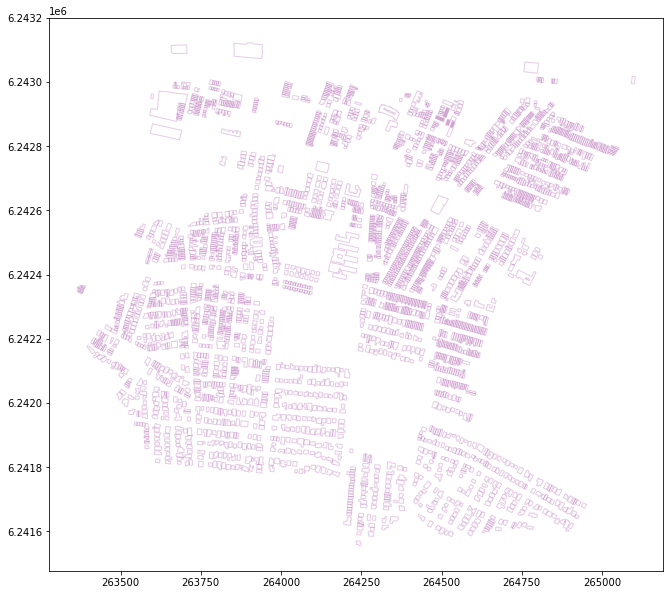

In [39]:
#-plot
fig, ax = plt.subplots(figsize=(11, 11))

gdf_copy.plot(ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)
if len(new_df1) > 0:
    new_df1.plot(ax=ax, edgecolor='red', facecolor='none')#, alpha=0.3)#, column='osm_building', legend=True)

#-- save
plt.savefig('./data/topologyFig', dpi=300)
#plt.show()

|  |  |
|:--------:|:--------:|
| ![ue-error.png](./data/ue-error.png)| **Challenges will be highlight in *'Red'***|
| ![ue.png](./data/ue.png)| **or none**|

<h2><center> If you continue without fixing the challenges, the BVPC value will not be true.  <br /><br /> Our goal is to be as representative as possible. </center></h2>

**If necessary; edit [OpenStreetMap](https://www.openstreetmap.org/about) and fix the challenge please.** 

<div class="alert alert-block alert-warning"><b>  </b> 

And remember.  
Geofabrik releases a ***fresh `.osm.pbf` EVERYDAY!***  
Give the OpenStreetMap server ***at least a day*** before attempting the process again.
    
**Alchemy is a process. Please be patient.**
</div>

<div class="alert alert-block alert-success"><b>BVPC = total population of a community divided by sum of building volume</b></div>

In [40]:
#gdf.height.unique()

In [41]:
#- area and volume
gdf2['area'] = gdf2['geometry'].area
gdf2['volume'] = gdf2['area'] * gdf2['height']

#- remove the volume of the ground floor (unoccupied) when building:levels > 7 [this is an arbitrary number based on local knowledge]
#- typically this space is reserved for some other function: retail, etc. 
gdf2['volume'] = [
    (row['volume'] - row['area'] * 2.8) if (
        row['social_facility'] is None and row['building:levels'] > 7 and 
        row['building'] in ['residential', 'apartments', 'student']
    ) else row['volume']
    for _, row in gdf2.iterrows()
]

gdf2['bvpc'] =  gdf2['volume'] / gdf2['pop'] 

In [42]:
print(gdf2['bvpc'].describe())

count    2996.000000
mean             inf
std              NaN
min        30.084609
25%        89.761428
50%       117.238453
75%       166.938368
max              inf
Name: bvpc, dtype: float64


In [43]:
bvpc = round(gdf2['volume'].sum() / est_pop, 3)
#bvpc = round( est_pop / gdf2['volume'].sum(), 3)

print('Building Volume Per Capita (BVPC):', bvpc)

Building Volume Per Capita (BVPC): 137.256


<div class="alert alert-block alert-info"><b></b>

**This BVPC value is general.**  

We can seperate `building:house` and `building:residential` to undertand the differences between ***formal and informal / social*** housing in this area.
    
**We want to understand the living space *(the cubic-meter BVPC value)* each person has in thier home**
</div>

In [44]:
#- formal
formal = gdf2[gdf2["building"].isin(['house', 'semidetached_house', 'terrace', 'apartment'])].copy()
f_pop = int(formal['pop'].sum())
#f_area = formal['area'].mean()

#- informal
informal = gdf2[gdf2["building"].isin(['residential', 'cabin'])].copy()
inf_pop = int(informal['pop'].sum())
#inf_area = formal['area'].mean()

#- student
stu = gdf2[gdf2["building"].isin(['student', 'dormitory'])].copy()
stu_pop = int(stu['pop'].sum())

#bvpc_formal = round(formal['volume'].sum() / est_pop, 3)
#bvpc_informal = round(informal['volume'].sum() / est_pop, 3)
#bvpc_stu = round(stu['volume'].sum() / est_pop, 3)
bvpc_formal = round(formal['volume'].sum() / formal['pop'].sum(), 3)
bvpc_informal = round(informal['volume'].sum() / informal['pop'].sum() if informal['pop'].sum() != 0 else 0, 3)
bvpc_stu = round(stu['volume'].sum() / stu['pop'].sum() if stu['pop'].sum() != 0 else 0, 3)

print('FORMAL: Population: ', f_pop, ' with Building Volume Per Capita (BVPC):', bvpc_formal)
print('')
print('STUDENT RESIDENCE: Population: ', stu_pop, ' with Building Volume Per Capita (BVPC):', bvpc_stu)
print('')
print('INFORMAL: Population: ', inf_pop, ' with Building Volume Per Capita (BVPC)', bvpc_informal)

FORMAL: Population:  11844  with Building Volume Per Capita (BVPC): 145.653

STUDENT RESIDENCE: Population:  45  with Building Volume Per Capita (BVPC): 109.497

INFORMAL: Population:  1279  with Building Volume Per Capita (BVPC) 77.813


In [45]:
#informal

<div class="alert alert-block alert-danger"><b>Warning: </b>
    

These are LoD1 3D City Models.  
LoD2 would offer a more representative BVPC [(Ghosh, T; et al. 2020)](https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs) value; when the complexity of the built environment increases.  

Think about a `house` with living space in the roof structure, so called *'attic living'*, or an `apartment` building with different levels, loft apartments and/or units in the turrets of a building.  

***consider***: this area seperates [building:cabin](https://wiki.openstreetmap.org/wiki/Tag:building%3Dcabin) from `building:residential` to more precisely represent informal structures without typical roof trussess but account for [social housing](https://en.wikipedia.org/wiki/Public_housing) that does</div></div>

**Now you do your community.** ~ If your area needs [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap) data and you want to contribute please follow the [Guide](https://wiki.openstreetmap.org/wiki/Beginners%27_guide).

<a id='Section3'></a>

<div class="alert alert-block alert-success"><b>3. Possible Secondary and Tertiary level conversations starters:</b></div>

| **Topic**                                | **Secondary Level Questions**                                                                                                                                                                                   | **Tertiary Level Questions**                                                                                                                                                                                                                   |
|------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Geography** | - Talk about the main difference between a globe and a map, and why we use map projections to represent the Earth on a flat surface<br>- Explain why different map projections are used for different purposes. For example, why might a Mercator projection be useful for navigation, but not for comparing the sizes of countries? | - Discuss why it is necessary to convert geographic coordinates (latitude and longitude) to a projected coordinate system in the context of the geospatial sciences. What are some potential issues if this conversion is not done? <br>- How does geodesy contribute to the geospatial sciences?|
| **Basic Understanding and Observations** | - What types of buildings are most common in the area (houses, apartments, retail, etc.)?<br>- Can you identify any patterns in the distribution of different types of buildings (e.g., are retail stores concentrated in certain areas)? | - How does the building stock composition (e.g., ratio of houses) correlate with the population? *demographics (e.g., age distribution, household size for the area will strengthen the analysis!* <br>- Analyze the relationship between building density and population. What urban planning theories can explain this relationship? |
| **Spatial Relationships and Impacts**    | - How does the location of residential areas compare to the location of retail and commercial areas?<br>- What impact might the density and distribution of buildings have on local traffic and transportation?<br>- How might the population distribution affect the demand for local services such as schools, hospitals, and parks? | - Evaluate the accessibility of essential services (e.g., healthcare, education) in relation to the population and building types.<br>- Assess the potential social and economic impacts of a proposed new residential or commercial development in the area.                  |
| **Socioeconomic and Environmental Considerations** | - **How can an increase in the population of an urban area affect the demand for housing and public services?** *(conversely what do the results of  [village]() indicate?)*<br>- Are there any correlations between the types of housing available and the household size? *additional demographics (e.g., income level) for the area will strengthen the analysis!*<br>- How might the current building stock and population influence the local economy? *demographics (e.g., age distribution, household size) for the area will strengthen the analysis!*<br>- What are some potential environmental impacts of the current building distribution, such as green space availability or pollution levels? | - **What are the potential socio-economic and environmental challenges associated with rapid population growth in urban areas, and how can urban planners address these challenges?** *(conversely what do the results of  [village]() indicate?)*<br>- How does the current building stock support or hinder sustainable development goals (e.g., energy efficiency, reduced carbon footprint)?<br>- What strategies could be implemented to increase the resilience of the community to environmental or economic changes?                       |
| **Future Planning and Development**      | - Based on the current building stock and population metrics, what areas might benefit from additional housing or commercial development?<br>- How could urban planners use this information to improve the quality of life in the area?<br>- What changes would you recommend to better balance residential, commercial, and recreational spaces? | - How might different zoning regulations impact the distribution of residential, commercial, and industrial buildings in the future?<br>- Propose urban design solutions that could improve the sustainability and livability of the area, considering both current metrics and future projections. |
| **Quantitative and Qualitative Research** | |- Design a research study to investigate the impact of building type diversity on community wellbeing. What methodologies would you use?<br>- Analyze historical data to understand trends in building development and population growth. How have these trends shaped the current urban landscape?<br>- Conduct a SWOT analysis (Strengths, Weaknesses, Opportunities, Threats) of the area based on the building stock and population metrics. |